# Demo:  Low-Rank Matrix Completion with Embeddings 

Low-rank matrix factorizations are key in PCA approximations, recommender systems, word embeddings and many other problems in machine leanring.  In this demo, you will learn to:

* Describe a low rank factorization of a matrix and the matrix completion problem
* Describe and implement an `Embedding` layer in `keras`.
* Build a simple neural network to perform the matrix completion

## Low-Rank Matrix Completion

A matrix `M` of shape `(n0,n1)` is said to have a *low-rank factorization* if it can be written as the product:

    M=A0.dot(A1.T)
    
where `A0` has shape `(n0,r)`, `A1` has shape `(n1,r)` and `r << n0` and `r << n1`.  The parameter `r` is called the *rank*.  The key property of a low-rank factorization is that the matrix `M` can be represented with much smaller number of parameters.  A general `(n0,n1)` matrix `M` requires `n0*n1` parameters.  However, the parameters in the two terms in the factorization require

     n0*r + n1*r = (n0+n1)*r
     
     
parameters.  If `r << n0,n1` then the number of parameters in the matrix factorization is much lower.  

One application of this factorization is called matrix completion.  Suppose we are given a subset of the indices, `M[i0,i1]` for a small number of locations `(i0,i1)`.  The matrix completion problem is to find the remaining matrix entries.  This is the basic problem in recommender systems.  If the matrix has a suffficiently low rank approximation, then this completion can be performed.  

We begin by loading standard packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

We also load packages from `tensorflow`.

In [2]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Embedding, Lambda, Input, Flatten, Dot
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

## Create Synthetic Data

To illustrate the low-rank factorization, we will create *synthetic* data from a random low-rank matrix.

In [3]:
n0 = 100
n1 = 80
nr = 5
A0 = np.random.normal(0,1/np.sqrt(nr), (n0,nr))
A1 = np.random.normal(0,1/np.sqrt(nr), (n1,nr))
M = A0.dot(A1.T)

The data consists of random samples of this matrix.  We will sample `ns=3000` of the `n0*n1=8000` entries of the matrix.

In [4]:
# Subsample the data
ns = 3000
I0 = np.random.randint(0, n0, (ns,))
I1 = np.random.randint(0, n1, (ns,))

y = np.zeros(ns)
for i in range(ns):
    i0 = I0[i]
    i1 = I1[i]
    y[i] = A0[i0,:].dot(A1[i1,:])

The training and test data arrays `Xtr` and `Xts` have two components:  a set of indices `I0` and a set of indices `I1`.  The output is the vector of matrix values: `y[j] = M[i0,i1]` at the location `i0=I0[j]`, `i1=I1[j]`.

In [5]:
# Train-test split
test_frac = 0.2
ntr = np.round((1-test_frac)*ns).astype(int)
nts = ns - ntr
Xtr = [I0[:ntr], I1[:ntr]]
ytr = y[:ntr]
Xts = [I0[ntr:], I1[ntr:]]
yts = y[ntr:]

## Neural Network Low-Rank Completion

We now build a simple neural network for matrix completion.  The key component is an `Embedding` layer.  An `Embedding` layers takes an integer index `i=0,1,...,n-1` and outputs a vector `W[i,:]` with some dimension `d`.  The vector `W[i,:]` is called the *embedding* of the index `i`.  The parameters in the embedding is the `n x d` matrix `W` with all the embeddings.  The dimension `d` is the *embedding dimension* and `n` is the *input dimension*.  

Now, if a matrix `M` has a factorization `M=A0.dot(A1.T)` then 

     M[i0,i1] = A0[i0,:].dot(A1[i1,:])
     
So, we can learn the `A0` and `A1` via embeddings.  

The details of the network are as follows.  

* The inputs are `ind_in0` and `ind_in1` which are the indices `i0` and `i1`.
* Each index goes to an `Embedding` layer which looks up the rows `A0[i0,:]` and `A1[i1,:]`.
* The outputs of the embedding are flattened, since by default they are matrices, not vectors.
* The  `Dot` layer takes the inner product of the two terms.

There is a small amount of regularization to control the size of the terms.

In [6]:
K.clear_session()
l2_reg = 1e-8

ind_in0  = Input(name='ind_in0', shape=(1,))
emb0 = Embedding(input_dim=n0, output_dim=nr,name='emb0',
                embeddings_regularizer=regularizers.l2(l2_reg))(ind_in0)
vec0 = Flatten(name='vec0')(emb0)
ind_in1  = Input(name='ind_in1', shape=(1,))
emb1 = Embedding(input_dim=n1, output_dim=nr,name='emb1',
                embeddings_regularizer=regularizers.l2(l2_reg))(ind_in1)
vec1 = Flatten(name='vec1')(emb1)
yhat = Dot(name='product',axes=1)([vec0,vec1])

mod = Model([ind_in0, ind_in1], yhat)
mod.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ind_in0 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
ind_in1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
emb0 (Embedding)                (None, 1, 5)         500         ind_in0[0][0]                    
__________________________________________________________________________________________________
emb1 (Embedding)                (None, 1, 5)         400         ind_in1[0][0]                    
_______________________________________________________________________________________

We next compile the model and initialize the embeddings with random matrices.

In [7]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
Ainit0 = np.random.normal(0,1/np.sqrt(nr), (n0,nr))
Ainit1 = np.random.normal(0,1/np.sqrt(nr), (n1,nr))
opt = Adam(lr=0.01)
mod.compile(optimizer=opt, loss='mean_absolute_error', metrics=['mean_absolute_error'])
mod.set_weights((Ainit0,Ainit1))

We now fit the network.  Since we need a large number of epochs, we will turn off the verbosity and instead use a `tqdm_notebook` progress bar.  You should see the `test` loss goes to zero, which means we are getting a perfect fit.

Note the large `batch_size=1000`.  This is typical for Embedding layers.

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]C:\Users\sdran\anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:38<00:00, 10.17it/s]


Text(0, 0.5, 'MAE')

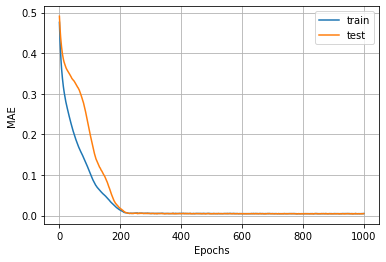

In [8]:
from tqdm import tqdm

num_epochs = 1000
loss = []
val_loss = []

# Loop over epochs
for i in tqdm(range(num_epochs)):
    
    # Run one epoch in the loop
    hist = mod.fit(Xtr,ytr,epochs=1,batch_size=1000, verbose=0, validation_data=(Xts,yts))
    val_loss.append(hist.history['val_loss'])
    loss.append(hist.history['loss'])
    
loss=np.array(loss).ravel()
val_loss=np.array(val_loss).ravel()

# Plot the training and test loss
plt.plot(loss)
plt.plot(val_loss)
plt.grid()
plt.legend(['train', 'test'])
plt.xlabel('Epochs')
plt.ylabel('MAE')

Finally, we display the predicted and true values on the test data.  You get a perfect match.

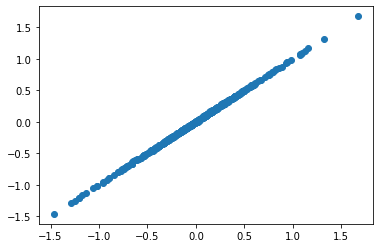

In [9]:
yhat = mod.predict(Xts)
plt.plot(yts,yhat,'o')